In [1]:
import numpy as np
from PIL import Image
from datetime import datetime
import cv2
import warnings
import scipy
import matplotlib.pyplot as plt
import timeit
from skimage.io import imread, imshow

In [2]:
FilePath = "C:\\Users\\ashis\\Documents\\Ashish\\EPR420\\ProjectRepository\\Gray_Scale_Conversion\\Images\\FilterTestImage.png"
FilePath = "C:\\Users\\ashis\\Documents\\Ashish\\EPR420\\ProjectRepository\\Gray_Scale_Conversion\\Images\\20230412_140209.jpg"
FilePath = "C:\\Users\\ashis\\Documents\\Ashish\\EPR420\\ProjectRepository\\Gray_Scale_Conversion\\Images\\imgArr0.png"
FilePath = "C:\\Users\\ashis\\Documents\\Ashish\\EPR420\\ProjectRepository\\Gray_Scale_Conversion\\Images\\imgArr10.png"
imgString = FilePath + ""

imgString = r"G:\My Drive\EPR_420\Code\TestImages\englishInsuranceform_lowRes.jpg"


imageObj = Image.open(imgString)
# image = image.resize((2, 4))
# imageObj.show()
print(imageObj.size) # Output: (1920, 1280)
imageArray = np.asarray(imageObj.convert('RGB'))


(1906, 2688)


#Print Commands

In [3]:
def Imshow(imgArr1, imgArr2):
    f, (plot1, plot2) = plt.subplots(1, 2)
    plot1.imshow(imgArr1, cmap='gray', vmin=0, vmax=255)
    plot2.imshow(imgArr2, cmap='gray', vmin=0, vmax=255)
    plt.show()

def PILImshow(imgArr1, imgArr2):
    imgArr1 = imgArr1.astype('uint8')
    imgArr2 = imgArr2.astype('uint8')
    Image.fromarray( imgArr1 , 'L').show()
    Image.fromarray( imgArr2 , 'L').show()
    Image.fromarray( imgArr1 , 'L').save(".\\Images\\imgArr1.png")
    Image.fromarray( imgArr2 , 'L').save(".\\Images\\imgArr2.png")

def BinImshow(imgArr1, flip):
    if(flip):
        imgArr1 = np.logical_not(imgArr1)
    imgArr1 = imgArr1*255
    imgArr1 = imgArr1.astype('uint8')
    f, (plot1) = plt.subplots(1, 1)
    plot1.imshow(imgArr1, cmap='gray', vmin=0, vmax=255)


def BinPILImshow(imgArr1, flip):
    if (flip):
        imgArr1 = np.logical_not(imgArr1)
    imgArr1 = imgArr1*255
    imgArr1 = imgArr1.astype('uint8')
    Image.fromarray( imgArr1 , 'L').show()

Gray-Scale Conversion

In [4]:
def ConvertToGrayScale(imageArray):
    grayScaleArray = 0.299*imageArray[:,:,0] + 0.587*imageArray[:,:,1] + 0.114*imageArray[:,:,2]
    return grayScaleArray.astype('uint8')

grayScaleArray = ConvertToGrayScale(imageArray)
# Image.fromarray( grayScaleArray , 'L').show()


In [5]:
# %time (ConvertToGrayScale(imageArray))

Sauvola Thresholding

Max = 252 Min = 0 R= 126.0


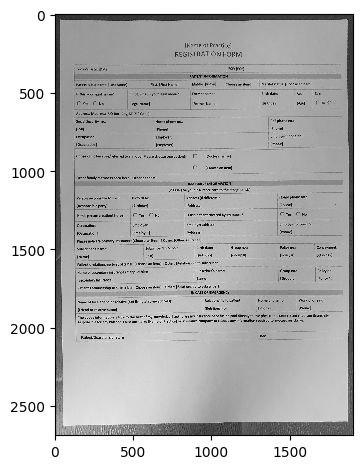

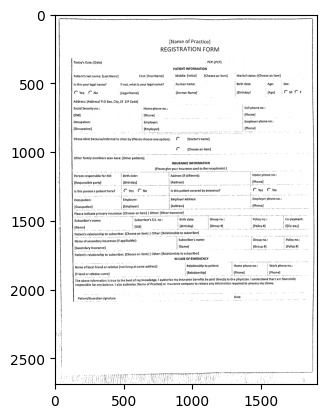

In [9]:
# Window using np.lib.stride_tricks.sliding_window_view

def Sauvola(grayScaleArray, windowSize, v):
    """
        The function thresholds an image according to Savola's thresholding algorithm in *insert pdf link*
  
        Parameters:
            grayScaleArray  (uint8) : 2d array of the image
            windowSize      (int)   : the window size of the
            v               (int)   : the k value    

        Returns:
            bool: A 2d Boolean array where true is foreground pixels and false is background pixels.
        """
    ThresholdOutArray = np.zeros(np.shape(grayScaleArray)) 
    SauvolaOutArray = np.zeros(np.shape(grayScaleArray)) 

    R = (np.amax(grayScaleArray)-np.amin(grayScaleArray))/2
    print("Max =", np.amax(grayScaleArray), "Min =", np.amin(grayScaleArray), "R=", R)

    mid = windowSize//2

    grayScaleArrayPadded = np.pad(grayScaleArray, mid, 'wrap')

    # np.shape(grayScaleArray) (3024, 4032)
    # np.shape(grayScaleArrayPadded) (3038, 4046)
    # np.shape(sliding_windows) (3024, 4032, 15, 15)
    
    sliding_windows = np.lib.stride_tricks.sliding_window_view(grayScaleArrayPadded, (windowSize, windowSize))

    tempArray = sliding_windows.reshape((sliding_windows.shape[0], sliding_windows.shape[1], windowSize*windowSize))
    mean_window = np.mean(tempArray, axis = 2)
    std_window = np.std(tempArray, axis = 2)

    ThresholdOutArray = mean_window*(1 + v*(std_window/R - 1))

    SauvolaOutArray = grayScaleArray < ThresholdOutArray
    # print (SauvolaOutArray)
    return SauvolaOutArray

# 15 pixels window size with k = 0.2 

# window size affects speed greatly, thickness a little bit.
# k value affects thickness greatly, a little bit like dilation.
SauvolaOutArray = Sauvola(grayScaleArray, 11, 0.3)
imshow(grayScaleArray, cmap='gray')
BinImshow(SauvolaOutArray, 1)


In [7]:
BinPILImshow(SauvolaOutArray, 1)


In [8]:
#size dx×dy or windowSize is defined to cover at least two image characters
def Background(grayScaleArray, SauvolaOutArray, windowSize):
    BackgroundOut = np.zeros(np.shape(grayScaleArray)) 
    nRows = np.shape(grayScaleArray)[0]
    nColumns = np.shape(grayScaleArray)[1] 

    sWindow = np.zeros((windowSize, windowSize))
    IWindow = np.zeros((windowSize, windowSize))
    mid = windowSize//2 

    for i in range(0, nRows):
        for j in range(0, nColumns):
            if (SauvolaOutArray[i,j] == 0):
                BackgroundOut[i,j] = grayScaleArray[i,j]
            else:
                for k in range(0, windowSize):
                    for l in range(0, windowSize):
                        sWindow[k, l] = SauvolaOutArray[(i-mid + k)%nRows, (j-mid + l)%nColumns] 
                        IWindow[k, l] = grayScaleArray[(i-mid + k)%nRows, (j-mid + l)%nColumns] 
                numeratorSum = 0
                denominatorSum = 0
                # for k in range(0, windowSize):
                #     for l in range(0, windowSize):
                #         numeratorSum += IWindow[k,l]*(1-sWindow[k,l])
                #         denominatorSum += (1-sWindow[k,l])
                numeratorSum = np.sum(IWindow*(1-sWindow))
                denominatorSum = np.sum(1-sWindow)
                BackgroundOut[i,j] = numeratorSum/denominatorSum
    return BackgroundOut.astype('uint8')

BackgroundOutArr = Background(grayScaleArray, SauvolaOutArray, 40)
Imshow(grayScaleArray, BackgroundOutArr)

PILImshow(grayScaleArray, BackgroundOutArr)

In [ ]:
def FinalThreshold(grayScaleArray, BackgroundOut, SauvolaOutArray, q = 0.6, p1 = 0.5, p2 = 0.8):
    numeratorSum = np.sum(BackgroundOut*(1-SauvolaOutArray))
    denominatorSum = np.sum(1-SauvolaOutArray)
    b = numeratorSum/denominatorSum
    # print("b =", b)
    δ = np.sum(BackgroundOut-grayScaleArray)/np.sum(SauvolaOutArray)
    # print("δ", δ)
    d = q*δ*((1-p2)/(1 + np.exp((-4*BackgroundOut)/(b*(1-p1)) + 2*(1+p1)/(1-p1)))) + p2
    # print(d.astype('uint8'))
    FinalThresholdOut = (BackgroundOut-grayScaleArray) > d
    return(FinalThresholdOut)

FinalThresholdOut = FinalThreshold(grayScaleArray, BackgroundOutArr, SauvolaOutArray)
BinImshow(SauvolaOutArray, 1)
BinImshow(FinalThresholdOut, 1)
BinPILImshow(FinalThresholdOut, 1)
# BinPILImshow(SauvolaOutArray, 1)

# print(FinalThresholdOut == SauvolaOutArray)
# print(np.min(FinalThresholdOut == SauvolaOutArray))

In [ ]:
def BinarizeImage(imageArray):
    grayScaleArray = ConvertToGrayScale(imageArray)
    SauvolaOutArray = Sauvola(grayScaleArray, 15, 0.2)
    # BackgroundOutArr = Background(grayScaleArray, SauvolaOutArray, 40)
    # FinalThresholdOut = FinalThreshold(grayScaleArray, BackgroundOutArr, SauvolaOutArray)
    return SauvolaOutArray

How np.lib.stride_tricks.sliding_window_view(arr, window_shape) works ↓

In [ ]:
import numpy as np

# Create a 2D array
arr = np.array([[1, 2, 3, 4],
                [5, 6, 7, 8],
                [9, 0, 1, 2],
                [1, 2, 3, 4]])

# Define the window size
window_shape = (2, 2)

# Create the moving window
moving_windows = np.lib.stride_tricks.sliding_window_view(arr, window_shape)

# print(moving_window)
# currently 3x3x2x2

print("moving_windows")
print(moving_windows.shape)
print(moving_windows)



mean_window = moving_windows.reshape((moving_windows.shape[0], moving_windows.shape[1], window_shape[0]*window_shape[1]))
mean_window = np.mean(mean_window, axis = 2)
print(mean_window)


std_window = moving_windows.reshape((moving_windows.shape[0], moving_windows.shape[1], window_shape[0]*window_shape[1]))
std_window = np.std(std_window, axis = 2)
print(std_window)




mean_window = np.mean(moving_windows, axis = 3)
mean_window = np.mean(mean_window, axis = 2)
print(mean_window)

# moving_window_partial_mean = np.mean(moving_window, axis = 3)

# print("moving_window_partial_mean")
# print(moving_window_partial_mean.shape)
# print(moving_window_partial_mean)

# moving_window_partial_again = np.mean(moving_window_partial_mean, axis = 2)

# print("moving_window_partial_again")
# print(moving_window_partial_again.shape)
# print(moving_window_partial_again)







# for i in range(len(moving_window)):
#     for j in range(len(moving_window[0])):
#         print(moving_window[i,j])


# print("Reshaped:")
# reshaped_array=np.reshape(moving_window,(9,2,2))
# print(reshaped_array)

# mean = np.mean(moving_window, axis = 1)
# print("mean.shape", mean.shape)
# print("mean")
# print(mean)

In [ ]:
# Window using splicing

def Sauvola(grayScaleArray, windowSize, v):
    """
        The function thresholds an image according to Savola's thresholding algorithm in *insert pdf link*
  
        Parameters:
            grayScaleArray  (uint8) : 2d array of the image
            windowSize      (int)   : the window size of the
            v               (int)   : the k value    

        Returns:
            bool: A 2d Boolean array where true is foreground pixels and false is background pixels.
        """
    ThresholdOutArray = np.zeros(np.shape(grayScaleArray)) 
    SauvolaOutArray = np.zeros(np.shape(grayScaleArray)) 

    R = (np.amax(grayScaleArray)-np.amin(grayScaleArray))/2
    print("Max =", np.amax(grayScaleArray), "Min =", np.amin(grayScaleArray), "R=", R)

    mid = windowSize//2

    grayScaleArrayPadded = np.pad(grayScaleArray, mid, 'wrap')
    nRows = np.shape(grayScaleArrayPadded)[0]
    nColumns = np.shape(grayScaleArrayPadded)[1]


    print("before for loop")

    for i in range(mid, nRows-mid):
        print("i =", i)
        for j in range(mid, nColumns-mid):
            window = grayScaleArrayPadded[i-mid:i+mid+1, j-mid:j+mid+1] 
            # print(window)
            ThresholdOutArray[i-mid,j-mid] = np.mean(window)*(1 + v*(np.std(window)/R - 1))

    print("after for loop")


    SauvolaOutArray = grayScaleArray < ThresholdOutArray
    # print (SauvolaOutArray)
    return SauvolaOutArray

# 15 pixels window size with k = 0.2 
SauvolaOutArray = Sauvola(grayScaleArray, 15, 0.2)
imshow(grayScaleArray, cmap='gray')
BinImshow(SauvolaOutArray, 1)


In [ ]:
# Manual Window.
def Sauvola(grayScaleArray, windowSize, v):
    ThresholdOutArray = np.zeros(np.shape(grayScaleArray)) 
    SauvolaOutArray = np.zeros(np.shape(grayScaleArray)) 

    nRows = np.shape(grayScaleArray)[0]
    nColumns = np.shape(grayScaleArray)[1]


    R = (np.amax(grayScaleArray)-np.amin(grayScaleArray))/2
    print("Max =", np.amax(grayScaleArray), "Min =", np.amin(grayScaleArray), "R=", R)

    window = np.zeros((windowSize, windowSize))
    mid = windowSize//2
    for i in range(0, nRows):
        for j in range(0, nColumns):
            for k in range(0, windowSize):
                for l in range(0, windowSize):
                    window[k, l] = grayScaleArray[(i-mid + k)%nRows, (j-mid + l)%nColumns] 
            
            
            ThresholdOutArray[i,j] = np.mean(window)*(1 + v*(np.std(window)/R - 1))

    SauvolaOutArray = grayScaleArray < ThresholdOutArray
    print (SauvolaOutArray)
    # SauvolaOutArray = SauvolaOutArray*255
    
    return SauvolaOutArray

# 15 pixels window size with k = 0.2 
SauvolaOutArray = Sauvola(grayScaleArray, 15, 0.2)
Imshow(grayScaleArray, SauvolaOutArray)
# PILImshow(grayScaleArray, SauvolaOutArray)
BinImshow(SauvolaOutArray, 1)
BinPILImshow(SauvolaOutArray, 1)